## NREL WIND Toolkit - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user git+http://github.com/HDFGroup/h5pyd.git
```

Then, you can make a configuration file at ~/.hscfg with contents like so:

```
# HDFCloud configuration file
hs_endpoint = https://developer.nrel.gov/api/hsds/
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyproj import Proj
import dateutil

## Basic Usage

In [2]:
# Open the wind data "file"
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/wtk-us.h5", 'r')  

In [3]:
list(f.attrs)  # list attributes belonging to the root group

[u'history']

In [4]:
f.attrs['history']   # attributes can be used to provide desriptions of the content

u'Produced by 3TIER, Inc. under NREL subcontract AGV-2-22460-01'

## Datasets

In [5]:
list(f)  # list the datasets in the file

[u'DIF',
 u'DNI',
 u'GHI',
 u'coordinates',
 u'datetime',
 u'inversemoninobukhovlength_2m',
 u'precipitationrate_0m',
 u'pressure_0m',
 u'pressure_100m',
 u'pressure_200m',
 u'relativehumidity_2m',
 u'status',
 u'temperature_100m',
 u'temperature_10m',
 u'temperature_120m',
 u'temperature_140m',
 u'temperature_160m',
 u'temperature_200m',
 u'temperature_2m',
 u'temperature_40m',
 u'temperature_60m',
 u'temperature_80m',
 u'winddirection_100m',
 u'winddirection_10m',
 u'winddirection_120m',
 u'winddirection_140m',
 u'winddirection_160m',
 u'winddirection_200m',
 u'winddirection_40m',
 u'winddirection_60m',
 u'winddirection_80m',
 u'windspeed_100m',
 u'windspeed_10m',
 u'windspeed_120m',
 u'windspeed_140m',
 u'windspeed_160m',
 u'windspeed_200m',
 u'windspeed_40m',
 u'windspeed_60m',
 u'windspeed_80m']

In [6]:
dset = f['windspeed_100m']
dset.shape

(61368, 1602, 2976)

In [7]:
dset.dtype

dtype('float32')

In [8]:
dset.shape[0] * dset.shape[1] * dset.shape[2] * 4  # aprox 1 TB per dataset!

1170300524544

In [9]:
dset.chunks

[24, 89, 186]

In [10]:
dset.chunks[0] * dset.chunks[1] * dset.chunks[2] # 397 kB per chunk

397296

## Time-slicing

Get the datetime index from the server and convert to a pandas dataframe for convenience:

In [11]:
dt = f["datetime"]
dt = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)
dt.head()

,datetime
0,2007-01-01 00:00:00
1,2007-01-01 01:00:00
2,2007-01-01 02:00:00
3,2007-01-01 03:00:00
4,2007-01-01 04:00:00


Extract indexes for a particular span of time:

In [12]:
twentyten = dt.loc[(dt.datetime >= '2010-01-01') & (dt.datetime < '2011-01-01')].index
twentyten

Int64Index([26304, 26305, 26306, 26307, 26308, 26309, 26310, 26311, 26312,
            26313,
            ...
            35054, 35055, 35056, 35057, 35058, 35059, 35060, 35061, 35062,
            35063],
           dtype='int64', length=8760)

Or a particular date:

In [13]:
timestep = dt.loc[dt.datetime == '2012-04-01 12:00:00'].index[0]
timestep

46020

## Map Data

In [14]:
%time data = dset[timestep,::8,::8]   # extract every 8th record at a particular time

CPU times: user 10.1 ms, sys: 4.36 ms, total: 14.5 ms
Wall time: 1.42 s


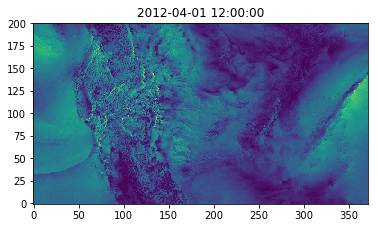

In [15]:
plt.title(str(dt.loc[timestep,"datetime"]))
plt.imshow(data, origin="lower")

In [16]:
%time data = dset[timestep,1100:1400,2000:2400]  # full-resolution subset

CPU times: user 12.5 ms, sys: 5.24 ms, total: 17.7 ms
Wall time: 636 ms


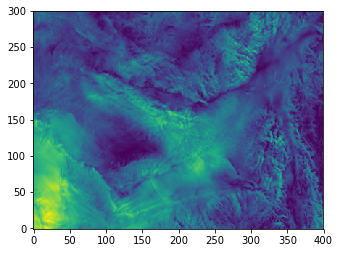

In [17]:
plt.imshow(data, origin="lower")

## Nearest Timeseries for given Lat/Lon

In [18]:
# This function finds the nearest x/y indices for a given lat/lon.
# Rather than fetching the entire coordinates database, which is 500+ MB, this
# uses the Proj4 library to find a nearby point and then converts to x/y indices
def indicesForCoord(f, lat_index, lon_index):
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = indicesForCoord( f, NewYorkCity[0], NewYorkCity[1] )

print("x,y indices for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(f["coordinates"][NewYorkCity_idx[0]][NewYorkCity_idx[1]]))

x,y indices for New York City: 		 (1044, 2375)
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 ( 40.709702, -73.992798)


In [19]:
# Get the entire 2010 timeseries data for a point in NYC
%time tseries = dset[min(twentyten):max(twentyten)+1, NewYorkCity_idx[0], NewYorkCity_idx[1]]

CPU times: user 4.93 ms, sys: 2.18 ms, total: 7.11 ms
Wall time: 1.07 s


In [20]:
len(tseries)   # 1 years * 365 days * 24 hours 

8760

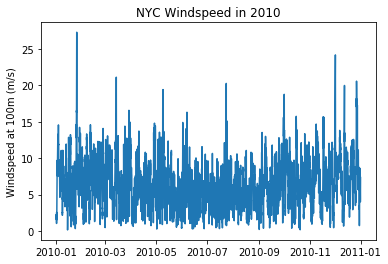

In [21]:
plt.plot(dt.iloc[twentyten,].datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("NYC Windspeed in 2010")

In [22]:
# This function fetches the 7-year timeseries in chunks of 8,000 elements
def entireTimeseries(dset, lat_index, lon_index):
    extent = dset.shape[0]
    tseries = np.zeros((extent,), dtype=dset.dtype)
    items_per_req = 8000 # extract time series in batches of 8000 elements
    count = (extent // items_per_req) + 1
    for i in range(count):
        start = i*items_per_req
        stop = start + items_per_req
        if stop > extent:
            stop = extent
        %time tseries[start:stop] = dset[start:stop, lat_index, lon_index ]
    return tseries

LongsPeak_idx = indicesForCoord(f, 40.2549, -105.6160)
tseries = entireTimeseries(dset,LongsPeak_idx[0],LongsPeak_idx[1])

CPU times: user 3.35 ms, sys: 489 µs, total: 3.83 ms
Wall time: 990 ms
CPU times: user 4.21 ms, sys: 1.03 ms, total: 5.24 ms
Wall time: 959 ms
CPU times: user 4.46 ms, sys: 1 ms, total: 5.46 ms
Wall time: 961 ms
CPU times: user 3.77 ms, sys: 921 µs, total: 4.69 ms
Wall time: 980 ms
CPU times: user 4.21 ms, sys: 913 µs, total: 5.12 ms
Wall time: 975 ms
CPU times: user 4.15 ms, sys: 1.04 ms, total: 5.19 ms
Wall time: 920 ms
CPU times: user 3.71 ms, sys: 871 µs, total: 4.58 ms
Wall time: 988 ms
CPU times: user 4.23 ms, sys: 832 µs, total: 5.06 ms
Wall time: 766 ms


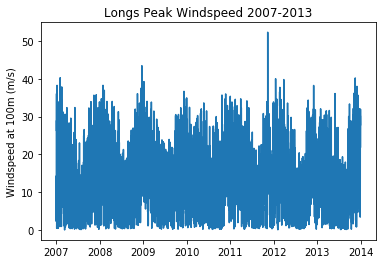

In [23]:
plt.plot(dt.datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("Longs Peak Windspeed 2007-2013")

## Windspeed Statistics

In [24]:
dt["windspeed"] = tseries
dt["year"] = dt["datetime"].apply(lambda x: x.year)
dt["month"] = dt["datetime"].apply(lambda x: x.month)
dt["day"] = dt["datetime"].apply(lambda x: x.day)
dt["hour"] = dt["datetime"].apply(lambda x: x.hour)

In [25]:
agg = dt.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="windspeed")
agg

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,17.782742,17.781574,17.936460,17.981829,17.954967,18.106070,18.217442,18.367193,18.447174,18.534664,...,18.363831,18.178539,17.854143,17.431709,17.194565,17.027246,16.904301,16.998867,17.139912,17.422821
2,16.437485,16.639477,16.689278,16.629135,16.662443,16.965656,17.273306,17.460009,17.616871,17.667582,...,17.730576,17.413107,17.092430,16.651268,16.390566,16.220219,16.195864,16.077782,16.211063,16.287605
3,14.604921,15.130107,15.412607,15.489409,15.776677,16.043848,16.277828,16.474186,16.677057,16.629452,...,16.498095,16.084057,15.284851,14.944521,14.798256,14.730160,14.745756,14.960455,14.894045,14.823627
4,13.538098,13.942963,14.095672,14.382008,14.624935,14.589562,14.894791,15.148313,15.371621,15.806626,...,15.633238,14.803759,14.014667,13.467426,13.230791,13.364985,13.376946,13.591709,13.539725,13.335716
5,11.307108,11.303395,11.524436,11.436130,11.292299,11.719445,11.939952,11.890996,12.257992,12.596297,...,12.245151,11.770721,11.352464,11.030233,11.190969,11.271287,11.059191,11.392616,11.504339,11.454047
6,12.146861,11.924526,11.722508,11.499505,11.589317,11.590261,11.332961,11.392022,11.676019,12.099078,...,11.952153,11.572066,11.499331,11.411350,11.469437,11.594026,11.791553,12.379775,12.270243,12.375328
7,7.504178,7.493124,7.438205,7.311883,7.368392,7.312094,7.841232,7.848489,7.851456,8.082863,...,8.146431,7.786299,7.660076,7.651398,7.561840,7.867813,8.126966,8.486354,7.907937,7.684139
8,8.010785,8.004921,7.972166,7.861540,7.758930,8.114224,8.464076,8.491234,8.781244,9.044336,...,9.444621,9.003101,8.690378,8.655358,8.424558,8.409269,8.399918,8.803268,8.915976,8.636556
9,9.860007,9.619100,9.669471,10.028005,10.206232,10.343493,10.769067,11.195759,11.499839,11.649380,...,11.362492,10.789354,10.624351,10.473779,10.323612,10.251211,10.327231,10.510371,10.489648,10.150558


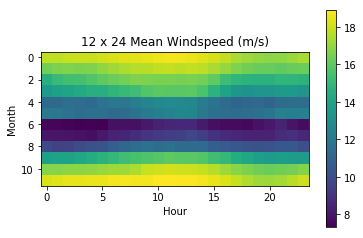

In [26]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean Windspeed (m/s)")
plt.colorbar()